In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, classification_report
import matplotlib.pyplot as plt

S:\anaconda3\envs\hh_casualml_test\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# ================ 1. ЗАГРУЗКА ДАННЫХ ================
print("Загрузка данных...")
triggers = pd.read_csv('triggers.csv', parse_dates=['date'])
actions = pd.read_csv('actions.csv', parse_dates=['date'])

# Определяем max_date для окон
max_date = max(triggers['date'].max(), actions['date'].max())

Загрузка данных...


In [3]:
# ================ 2. ПОДГОТОВКА ПРИЗНАКОВ ================
print("Подготовка признаков...")

def aggregate_features(df, by, date_col, windows, col, max_date):
    """Агрегация признаков по временным окнам"""
    chunks = []
    for w in tqdm(windows, desc=f'agg {col} windows'):
        start = max_date - pd.Timedelta(days=w)
        df_w = df[df[date_col] >= start]
        agg = (
            df_w
            .groupby(by)[col]
            .agg(count='count', unique='nunique')
            .rename(columns={
                'count': f'count_{w}d',
                'unique': f'unique_{w}d'
            })
        )
        chunks.append(agg)
    return pd.concat(chunks, axis=1).fillna(0)

# Строим фичи из triggers
windows = [7, 14, 30]
f_tr = aggregate_features(triggers, 'guid', 'date', windows, 'trigger', max_date)
f_ty = aggregate_features(triggers, 'guid', 'date', windows, 'type', max_date)

# Добавляем префиксы
f_tr = f_tr.add_prefix('tr_')
f_ty = f_ty.add_prefix('ty_')

# Агрегация признаков из actions
act_agg = (
    actions
    .groupby('guid')
    .agg(
        shows_count=('date', 'count'),
        positive_shows=('result', 'sum'),
        last_show=('date', 'max')
    )
)
act_agg['days_since_last_show'] = (
        max_date - act_agg['last_show']
).dt.days.fillna(999)

# Объединяем все признаки
features = (
    f_tr
    .join(f_ty, how='outer')
    .join(act_agg, how='outer')
    .fillna({
        'shows_count': 0,
        'positive_shows': 0,
        'days_since_last_show': 999
    })
)
features['user_ctr'] = (
        features['positive_shows'] / features['shows_count'].replace(0, 1)
)

# Добавляем recency из triggers
last_visit = triggers.groupby('guid')['date'].max()
features['days_since_last_visit'] = (
        max_date - last_visit
).dt.days.fillna(999)

# Сохраняем признаки
features.reset_index().to_csv('features_xgb.csv', index=False)
print(f"Признаки сохранены, размер: {features.shape}")

Подготовка признаков...


agg trigger windows:   0%|          | 0/3 [00:00<?, ?it/s]

agg type windows:   0%|          | 0/3 [00:00<?, ?it/s]

Признаки сохранены, размер: (1009806, 18)


In [9]:
# ================ 3. ПОДГОТОВКА ДАННЫХ ДЛЯ ОБУЧЕНИЯ ================
print("Подготовка данных для обучения...")

# Соединяем признаки с целевой переменной
feat = pd.read_csv('features_xgb.csv')
X = feat.drop(columns=['guid', 'last_show', 'shows_count', 'positive_shows', 'days_since_last_show', 'user_ctr'])

# загружаем признаки и метки
feat = pd.read_csv('features_xgb.csv')
acts = pd.read_csv('actions.csv', parse_dates=['date'])
df = feat.merge(acts[['guid','result']], on='guid').dropna(subset=['result'])
df = df.drop(["guid","last_show"], axis=1)
train_df = pd.DataFrame(df)
train_df.to_csv('train_data.csv', index=False)

# Готовим X и y
X = train_df.drop(columns=['result'])
y = train_df['result']

# Разбиение на train/val/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

Подготовка данных для обучения...


In [10]:
X_train

,tr_count_7d,tr_unique_7d,tr_count_14d,tr_unique_14d,tr_count_30d,tr_unique_30d,ty_count_7d,ty_unique_7d,ty_count_14d,ty_unique_14d,ty_count_30d,ty_unique_30d,shows_count,positive_shows,days_since_last_show,user_ctr,days_since_last_visit
226869,44.0,7.0,58.0,11.0,107.0,12.0,44.0,2.0,58.0,2.0,107.0,2.0,2.0,0.0,11.0,0.0,0
229294,0.0,0.0,2.0,2.0,2.0,2.0,0.0,0.0,2.0,1.0,2.0,1.0,1.0,0.0,13.0,0.0,13
34458,246.0,1.0,334.0,2.0,355.0,2.0,246.0,1.0,334.0,1.0,355.0,1.0,2.0,0.0,0.0,0.0,0
10450,48.0,10.0,70.0,12.0,106.0,34.0,48.0,2.0,70.0,2.0,106.0,2.0,2.0,1.0,1.0,0.5,0
216320,7.0,6.0,13.0,8.0,415.0,25.0,7.0,1.0,13.0,1.0,415.0,3.0,2.0,0.0,2.0,0.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
355262,0.0,0.0,0.0,0.0,37.0,14.0,0.0,0.0,0.0,0.0,37.0,1.0,1.0,0.0,24.0,0.0,24
208257,31.0,9.0,202.0,39.0,233.0,43.0,31.0,2.0,202.0,3.0,233.0,3.0,2.0,0.0,4.0,0.0,0
60817,24.0,9.0,30.0,11.0,85.0,14.0,24.0,2.0,30.0,2.0,85.0,2.0,2.0,0.0,8.0,0.0,0
258681,36.0,17.0,409.0,73.0,443.0,79.0,36.0,2.0,409.0,2.0,443.0,2.0,1.0,0.0,11.0,0.0,1


In [12]:
# ================ 4. ОБУЧЕНИЕ МОДЕЛИ ================
print("Обучение модели...")

# Параметры для балансировки классов
ratio = (y_train == 0).sum() / (y_train == 1).sum()

# Обучение модели
model = XGBClassifier(
    eval_metric='logloss',
    scale_pos_weight=ratio,
    n_estimators=100,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    min_child_weight=1,
    gamma=0,
    reg_alpha=0,
    reg_lambda=1,
)
model.fit(X_train, y_train, verbose=100)

Обучение модели...


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=0, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=1, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [13]:
# ================ 5. ОЦЕНКА МОДЕЛИ ================
print("Оценка модели...")

# Предсказания на тестовой выборке
y_proba = model.predict_proba(X_test)[:, 1]
roc = roc_auc_score(y_test, y_proba)
print(f"ROC-AUC: {roc:.4f}")

Оценка модели...
ROC-AUC: 0.9964


In [16]:
def simulate_campaign_fast(thresholds, freq_days=14):
    """
    Оптимизированная симуляция кампании для разных порогов вероятности
    """
    results = []

    train_features = [
        'tr_count_7d', 'tr_unique_7d', 'tr_count_14d', 'tr_unique_14d', 'tr_count_30d', 'tr_unique_30d',
        'ty_count_7d', 'ty_unique_7d', 'ty_count_14d', 'ty_unique_14d', 'ty_count_30d', 'ty_unique_30d',
        'shows_count', 'positive_shows', 'days_since_last_show', 'user_ctr', 'days_since_last_visit'
    ]

    # 1. Предварительно вычисляем вероятности для всех пользователей
    print("Прогнозирование вероятностей конверсии...")
    probs = model.predict_proba(feat[train_features])[:, 1]

    # 2. Создаем словарь {guid: prob} для быстрого доступа O(1)
    guid_to_prob = dict(zip(feat['guid'], probs))

    # 3. Предварительно обрабатываем данные о посещениях
    print("Обработка данных о посещениях...")
    # Берем только нужные колонки и удаляем дубликаты
    user_visits = triggers[['guid', 'date']].drop_duplicates()
    # Фильтруем только пользователей, для которых есть прогнозы
    user_visits = user_visits[user_visits['guid'].isin(guid_to_prob.keys())]
    # Сортируем по дате
    user_visits = user_visits.sort_values('date')

    # 4. Группируем пользователей по датам для быстрого доступа
    date_users = {}
    for date, group in user_visits.groupby('date'):
        date_users[date] = set(group['guid'])  # Множество для быстрого поиска

    # 5. Сортируем даты заранее
    dates = sorted(date_users.keys())

    # 6. Запускаем симуляцию для каждого порога
    for threshold in tqdm(thresholds, desc="Симуляция для порогов"):
        total_shows = 0
        total_conversions = 0
        last_shown = {}  # guid -> дата последнего показа

        for date in dates:
            for guid in date_users[date]:
                # Получаем вероятность из словаря (быстрый доступ)
                prob = guid_to_prob[guid]

                # Пропускаем если ниже порога
                if prob < threshold:
                    continue

                # Проверяем ограничение на частоту
                if guid in last_shown:
                    days_since_last = (date - last_shown[guid]).days
                    if days_since_last < freq_days:
                        continue

                # Показываем баннер
                total_shows += 1
                last_shown[guid] = date

                # Определяем конверсию по фактической вероятности
                if np.random.random() < prob:
                    total_conversions += 1

        # Рассчитываем метрики
        spend = total_shows  # $1 за показ
        revenue = total_conversions * 5  # $5 за конверсию
        balance = revenue - spend
        turnover = revenue + spend

        results.append({
            'threshold': threshold,
            'shows': total_shows,
            'conversions': total_conversions,
            'spend': spend,
            'revenue': revenue,
            'balance': balance,
            'turnover': turnover,
            'conv_rate': total_conversions / total_shows if total_shows > 0 else 0
        })

    return pd.DataFrame(results)

# Генерируем список порогов для проверки
thresholds = np.linspace(0.05, 0.95, 19)  # от 0.05 до 0.95 с шагом 0.05
simulation_results = simulate_campaign_fast(thresholds)

Прогнозирование вероятностей конверсии...
Обработка данных о посещениях...


Симуляция для порогов:   0%|          | 0/19 [00:00<?, ?it/s]

In [17]:

# ================ 7. АНАЛИЗ РЕЗУЛЬТАТОВ ================
print("Анализ результатов симуляции...")

# Отбираем только варианты с положительным балансом
profitable = simulation_results[simulation_results['balance'] >= 0]

if len(profitable) > 0:
    # Находим порог с максимальным оборотом при положительном балансе
    best_row = profitable.loc[profitable['turnover'].idxmax()]
    best_threshold = best_row['threshold']

    print("\n=== ОПТИМАЛЬНЫЙ ПОРОГ ДЛЯ МАКСИМИЗАЦИИ ОБОРОТА ===")
    print(f"Порог вероятности: {best_threshold:.4f}")
    print(f"Показы: {best_row['shows']}")
    print(f"Конверсии: {best_row['conversions']}")
    print(f"Расходы: ${best_row['spend']}")
    print(f"Доходы: ${best_row['revenue']}")
    print(f"Баланс: ${best_row['balance']}")
    print(f"Оборот: ${best_row['turnover']}")
    print(f"Конверсия: {best_row['conv_rate']:.2%}")
else:
    print("Не найдено вариантов с положительным балансом. Попробуйте другие параметры модели.")

Анализ результатов симуляции...

=== ОПТИМАЛЬНЫЙ ПОРОГ ДЛЯ МАКСИМИЗАЦИИ ОБОРОТА ===
Порог вероятности: 0.3000
Показы: 20980.0
Конверсии: 20561.0
Расходы: $20980.0
Доходы: $102805.0
Баланс: $81825.0
Оборот: $123785.0
Конверсия: 98.00%



Анализ завершен. Результаты сохранены в simulation_results.png


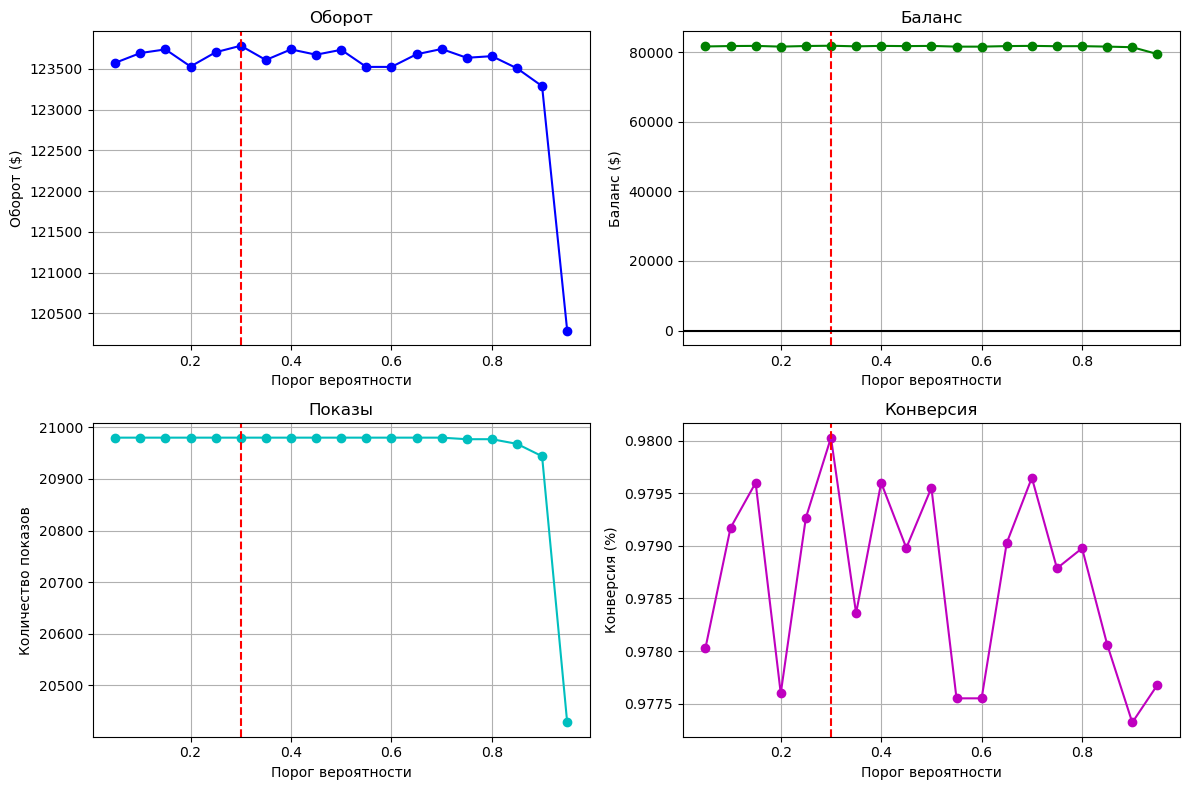

In [18]:
# ================ 8. ВИЗУАЛИЗАЦИЯ ================
plt.figure(figsize=(12, 8))

# График оборота
plt.subplot(2, 2, 1)
plt.plot(simulation_results['threshold'], simulation_results['turnover'], 'b-', marker='o')
plt.axvline(x=best_threshold, color='r', linestyle='--')
plt.title('Оборот')
plt.xlabel('Порог вероятности')
plt.ylabel('Оборот ($)')
plt.grid(True)

# График баланса
plt.subplot(2, 2, 2)
plt.plot(simulation_results['threshold'], simulation_results['balance'], 'g-', marker='o')
plt.axvline(x=best_threshold, color='r', linestyle='--')
plt.axhline(y=0, color='k', linestyle='-')
plt.title('Баланс')
plt.xlabel('Порог вероятности')
plt.ylabel('Баланс ($)')
plt.grid(True)

# График количества показов
plt.subplot(2, 2, 3)
plt.plot(simulation_results['threshold'], simulation_results['shows'], 'c-', marker='o')
plt.axvline(x=best_threshold, color='r', linestyle='--')
plt.title('Показы')
plt.xlabel('Порог вероятности')
plt.ylabel('Количество показов')
plt.grid(True)

# График конверсии
plt.subplot(2, 2, 4)
plt.plot(simulation_results['threshold'], simulation_results['conv_rate'], 'm-', marker='o')
plt.axvline(x=best_threshold, color='r', linestyle='--')
plt.title('Конверсия')
plt.xlabel('Порог вероятности')
plt.ylabel('Конверсия (%)')
plt.grid(True)

plt.tight_layout()
plt.savefig('simulation_results.png')

print("\nАнализ завершен. Результаты сохранены в simulation_results.png")

In [19]:
# ================ 9. СОХРАНЕНИЕ МОДЕЛИ И СТРАТЕГИИ ================
import pickle
with open('campaign_model.pkl', 'wb') as f:
    pickle.dump({
        'model': model,
        'optimal_threshold': best_threshold,
        'freq_cap_days': 14
    }, f)

print("Модель и стратегия сохранены в campaign_model.pkl")

Модель и стратегия сохранены в campaign_model.pkl
